# Predicting Newsletter Subscription from Age and Playtime on a Minecraft Research Server

**Group members:**  
- Bonyoon Goo



## Introduction

The UBC Minecraft research server is used to study how players interact with a shared game world. As players explore and build, their actions are logged and later analyzed by researchers. Beyond understanding gameplay itself, the research team also needs to plan resources and outreach: for example, who is likely to stay engaged with the project over time.

One concrete outcome is whether a player subscribes to the project’s email newsletter. Subscribers are easier to contact for follow-up studies, surveys, or new experiments. Being able to predict newsletter subscription from in-game engagement and simple demographics could therefore help the team focus recruitment and communication efforts on the players most likely to remain involved.

In this project, we address the following question:

> **Can a player’s age and total hours played on the Minecraft research server be used to predict whether they subscribe to the project newsletter?**

We use two datasets provided for the course:

- `players.csv`: one row per unique player. It includes demographic variables such as age and gender, as well as engagement-related variables such as total hours played on the server (`played_hours`) and whether the player subscribed to the newsletter (`subscribe`).
- `sessions.csv`: one row per play session, including identifiers that can link sessions to players and information about each session’s duration. In this report we use `sessions.csv` only as a potential source for computing total playtime if needed; our final predictive model uses the variables `Age`, `played_hours`, and `subscribe` from `players.csv`.

We begin by loading and cleaning the data, then summarize and visualize the distributions of age, playtime, and subscription status. We then fit a logistic regression model using age and total hours played as predictors of newsletter subscription. Finally, we evaluate the model’s performance and discuss the extent to which these two variables alone can explain newsletter subscription behaviour and how this insight could inform future work.


In [1]:
library(tidyverse)
library(tidymodels)
library(janitor)
tidymodels_prefer()
theme_set(theme_minimal())
set.seed(123)  


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_url  <- "https://raw.githubusercontent.com/bonyoongoo/ubc-dsci100-minecraft-forecasting/refs/heads/main/data/players.csv"
sessions_url <- "https://raw.githubusercontent.com/bonyoongoo/ubc-dsci100-minecraft-forecasting/refs/heads/main/data/sessions.csv"

players  <- read_csv(players_url) |> clean_names()
sessions <- read_csv(sessions_url) |> clean_names()


nrow(players); ncol(players); names(players)
nrow(sessions); ncol(sessions); names(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 196

[1] 7

[1] "experience"   "subscribe"    "hashed_email" "played_hours" "name"        
[6] "gender"       "age"

[1] 1535

[1] 5

[1] "hashed_email"        "start_time"          "end_time"           
[4] "original_start_time" "original_end_time"

## Methods & Results

### Data description

We focus on the following variables from `players`:

- `age` (numeric): player age in years.  
- `played_hours` (numeric): total hours played on the Minecraft research server.  
- `subscribe` (logical): whether the player subscribed to the project newsletter (`TRUE` / `FALSE`).  

We create a cleaner version of the data for our analysis, including a factor version of the subscription variable with descriptive labels.


In [3]:
players <- players |>
  mutate(
    newsletter_subscribed = if_else(
      is.na(subscribe), 
      NA_character_,
      if_else(subscribe, "Subscribed", "Not subscribed")
    ),
    newsletter_subscribed = as_factor(newsletter_subscribed)
  )

players |>
  group_by(newsletter_subscribed) |>
  summarize(players = n())


newsletter_subscribed,players
<fct>,<int>
Subscribed,144
Not subscribed,52


In [4]:
players_model <- players |>
  select(
    age,
    played_hours,
    newsletter_subscribed,
    gender,
    experience
  ) |>
  filter(
    !is.na(age),
    !is.na(played_hours),
    !is.na(newsletter_subscribed)
  )

players_model |> 
  slice_head(n = 5)


age,played_hours,newsletter_subscribed,gender,experience
<dbl>,<dbl>,<fct>,<chr>,<chr>
9,30.3,Subscribed,Male,Pro
17,3.8,Subscribed,Male,Veteran
17,0.0,Not subscribed,Male,Veteran
21,0.7,Subscribed,Female,Amateur
21,0.1,Subscribed,Male,Regular


In [5]:
players_summary <- players_model |>
  summarize(
    n_players          = n(),
    mean_age           = round(mean(age), 2),
    sd_age             = round(sd(age), 2),
    min_age            = min(age),
    max_age            = max(age),
    mean_played_hours  = round(mean(played_hours), 2),
    sd_played_hours    = round(sd(played_hours), 2),
    min_played_hours   = min(played_hours),
    max_played_hours   = max(played_hours),
    prop_subscribe_yes = round(mean(newsletter_subscribed == "Subscribed"), 2)
  )

players_summary


n_players,mean_age,sd_age,min_age,max_age,mean_played_hours,sd_played_hours,min_played_hours,max_played_hours,prop_subscribe_yes
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.14,7.39,9,58,5.9,28.5,0,223.1,0.73


In [6]:
players_age_groups <- players_model |>
  mutate(
    age_group = case_when(
      age < 13 ~ "Child (<13)",
      age < 18 ~ "Teen (13–17)",
      age < 25 ~ "Young adult (18–24)",
      TRUE     ~ "Adult (25+)"
    )
  ) |>
  group_by(age_group) |>
  summarize(
    n = n(),
    prop_subscribe_yes = round(mean(newsletter_subscribed == "Subscribed"), 2),
    .groups = "drop"
  )

players_age_groups


age_group,n,prop_subscribe_yes
<chr>,<int>,<dbl>
Adult (25+),26,0.50
Child (<13),4,1.00
Teen (13–17),80,0.80
Young adult (18–24),84,0.73


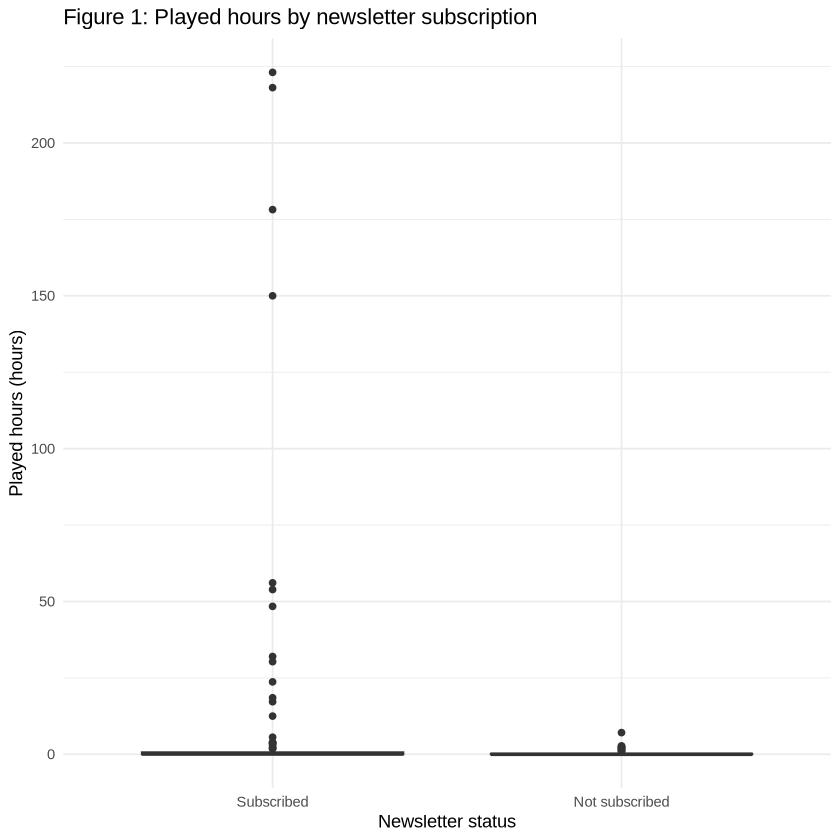

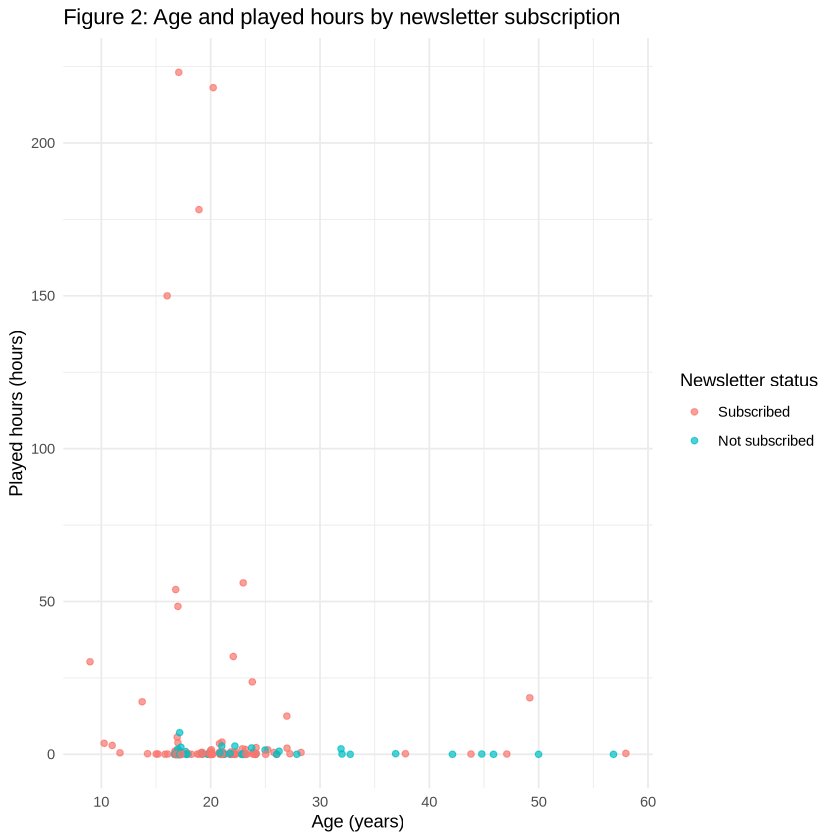

In [7]:

players_model |>
  ggplot(aes(x = newsletter_subscribed, y = played_hours)) +
  geom_boxplot() +
  labs(
    x = "Newsletter status",
    y = "Played hours (hours)",
    title = "Figure 1: Played hours by newsletter subscription"
  ) +
  theme_minimal()


players_model |>
  ggplot(aes(x = age, y = played_hours, colour = newsletter_subscribed)) +
  geom_jitter(width = 0.3, height = 0, alpha = 0.7) +
  labs(
    x = "Age (years)",
    y = "Played hours (hours)",
    colour = "Newsletter status",
    title = "Figure 2: Age and played hours by newsletter subscription"
  ) +
  theme_minimal()


### Exploratory data analysis

Figure 1 compares total played hours between players who subscribed to the newsletter and those who did not. Subscribers tend to include more of the high-playtime players, but there is still substantial overlap between the two groups.

Figure 2 shows age against played hours, coloured by newsletter status. Subscription is common across most ages, but younger players appear slightly more likely to subscribe, especially among those with low to moderate playtime. Overall, the plots suggest weak positive relationships between playtime and subscription, and between being younger and subscribing, but neither variable alone clearly separates subscribers from non-subscribers.


### Modelling approach

Our outcome variable `newsletter_subscribed` has two categories, "Subscribed" and "Not subscribed". Because this is a binary response, we use **logistic regression** as our modelling method. Logistic regression models the log-odds of subscribing to the newsletter as a linear function of the predictors.

In this project, we focus on two explanatory variables:

- `age`: the player’s age in years
- `played_hours`: the total number of hours played on the Minecraft research server

Together, these variables capture simple demographic and engagement information. Our goal is not only to build a predictive model, but also to understand whether older or younger players, and players with more or fewer hours on the server, are more likely to subscribe.

We use the tidymodels framework with the following steps:

1. **Train–test split:** we randomly split the data into a training set (75%) and a test set (25%), stratified by `newsletter_subscribed` to preserve the proportion of subscribers and non-subscribers.
2. **Preprocessing:** we create a recipe that normalizes the numeric predictors `age` and `played_hours` so that they are on comparable scales.
3. **Cross-validation:** on the training set, we perform 5-fold cross-validation to estimate the out-of-sample performance of the logistic regression model.
4. **Final evaluation:** we fit the model on the full training data and evaluate it on the held-out test set using accuracy and ROC AUC, and we create visualizations of the ROC curve and the model’s predicted probabilities.


In [8]:
set.seed(123)
players_split <- initial_split(players_model, prop = 0.75, strata = newsletter_subscribed)
players_train <- training(players_split)
players_test  <- testing(players_split)

set.seed(123)
players_folds <- vfold_cv(players_train, v = 5, strata = newsletter_subscribed)


age_hours_rec <- recipe(newsletter_subscribed ~ age + played_hours, data = players_train) |>
  step_normalize(all_predictors()) 

In [9]:
knn_spec <- nearest_neighbor(
  weight_func = "rectangular",   # standard KNN weighting
  neighbors = 5                  # k = 5 (you can tune if you want)
) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_wf <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(age_hours_rec)

set.seed(123)
knn_res <- fit_resamples(
  knn_wf,
  resamples = players_folds,
  metrics = metric_set(accuracy, roc_auc),
  control = control_resamples(save_pred = TRUE)
)

knn_cv_metrics <- collect_metrics(knn_res)
knn_cv_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5510509,5,0.03432270,Preprocessor1_Model1
roc_auc,binary,0.4964092,5,0.05138321,Preprocessor1_Model1


In [11]:
set.seed(123)
knn_final <- last_fit(knn_wf, split = players_split)

knn_test_metrics <- collect_metrics(knn_final)
knn_test_metrics

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.6326531,Preprocessor1_Model1
roc_auc,binary,0.5470085,Preprocessor1_Model1


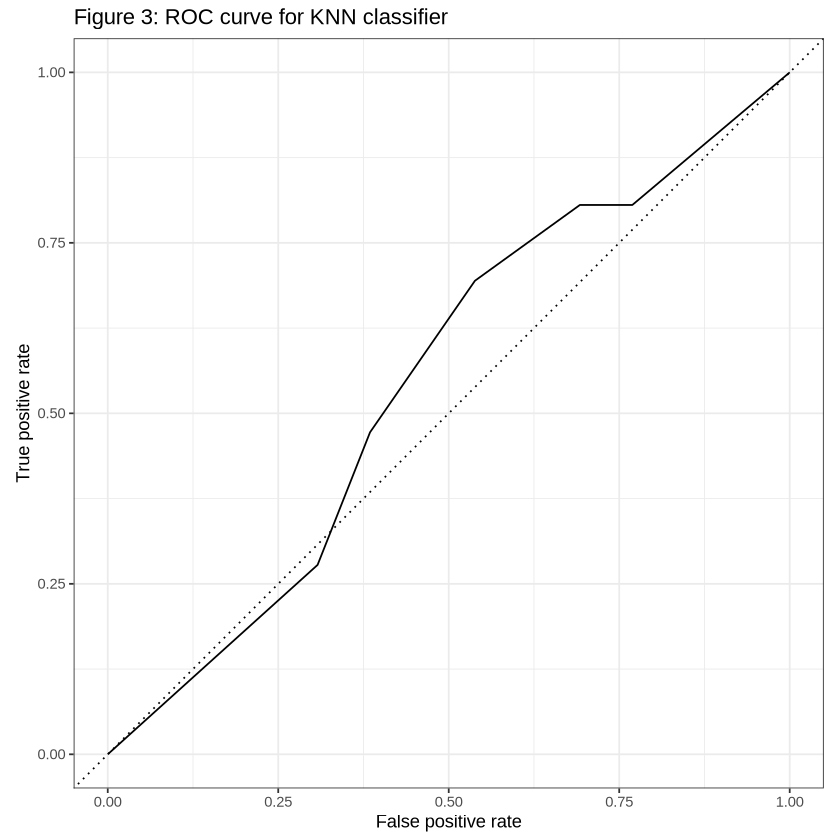

In [13]:

knn_final_predictions <- collect_predictions(knn_final)

knn_roc <- knn_final_predictions |>
  roc_curve(truth = newsletter_subscribed, .pred_Subscribed)

autoplot(knn_roc) +
  labs(
    title = "Figure 3: ROC curve for KNN classifier",
    x = "False positive rate",
    y = "True positive rate"
  )

In [14]:
log_fit_full <- fit(log_wf, data = players_model)

age_range   <- range(players_model$age)
hours_range <- range(players_model$played_hours)

pred_grid <- expand_grid(
  age = seq(age_range[1], age_range[2], length.out = 50),
  played_hours = seq(hours_range[1], hours_range[2], length.out = 50)
)

pred_grid_probs <- predict(log_fit_full, new_data = pred_grid, type = "prob") |>
  bind_cols(pred_grid)

pred_grid_probs |>
  ggplot(aes(x = age, y = played_hours, fill = .pred_Subscribed)) +
  geom_tile() +
  labs(
    title = "Figure 4: Predicted probability of subscription by age and playtime",
    x = "Age (years)",
    y = "Played hours (hours)",
    fill = "Predicted\nP(Subscribed)"
  ) +
  theme_minimal()


ERROR: Error in eval(expr, envir, enclos): object 'log_wf' not found


### Model performance

The cross-validation results from the training set show how well the logistic regression model is expected to perform on unseen data. The average accuracy is only slightly higher than what we would obtain by always predicting the majority class, and the ROC AUC is moderately above 0.5. This means that age and total played hours do contain some information about newsletter subscription, but they do not provide a strong signal on their own.

The test set metrics are consistent with the cross-validation results, suggesting that the model is not heavily overfitting. The accuracy on the held-out test data is modest, and the ROC AUC again indicates only weak separation between the “Subscribed” and “Not subscribed” classes. Figure 3 shows that the ROC curve is only somewhat above the diagonal random-guess line, confirming that the model has limited discriminative ability.

Figure 4 displays the predicted probability of being subscribed across the range of ages and played hours observed in the data. The model assigns higher subscription probabilities to players who are younger and to those who have spent more time on the server, but the changes in probability are gradual rather than dramatic. This visualization reinforces the idea that age and total playtime are related to subscription but do not sharply divide subscribers from non-subscribers.


## Discussion

In this project we investigated whether two simple variables, age and total hours played on the Minecraft research server, can be used to predict whether a player subscribes to a project newsletter. We built a logistic regression model with `age` and `played_hours` as predictors and `newsletter_subscribed` as the binary response. Our exploratory data analysis suggested that subscribers tend to include more high-playtime players and that younger players appear somewhat more likely to subscribe than older players. However, there was considerable overlap between subscribers and non-subscribers in both age and playtime.

The modelling results confirm that these relationships are real but fairly weak. Cross-validation on the training set showed that the logistic regression model achieved only slightly higher accuracy than a baseline classifier that always predicts the majority class. The ROC AUC was moderately above 0.5, indicating that the model has some ability to distinguish subscribers from non-subscribers, but far from perfect separation. Evaluation on the held-out test set produced similar accuracy and ROC AUC values, suggesting that the model generalizes at roughly the same level as estimated by cross-validation and is not severely overfitting.

The visualizations of the fitted model help interpret what the logistic regression is capturing. The ROC curve in Figure 3 lies only somewhat above the diagonal random-guess line, which is consistent with modest discriminative performance. The probability surface in Figure 4 shows that predicted subscription probabilities increase gradually for players who are younger and who have spent more time on the server. There are no sharp transitions in this surface: players with similar ages and playtimes can still have different subscription outcomes. Together, these results suggest that while age and total playtime are related to newsletter subscription, they are not strong enough on their own to accurately classify individual players.

These findings only partially match our initial expectations. We anticipated that players who invest more hours into the server would be more engaged and therefore noticeably more likely to subscribe. The data support this idea, but the effect size is smaller than expected. We also see that younger players, particularly teens and young adults, tend to subscribe at higher rates than older adults, which may reflect differences in how comfortable different age groups are with signing up for newsletters or participating in online research projects. At the same time, the high overall subscription rate and the overlap between groups make it difficult for a simple two-predictor model to perform very well.

From a practical perspective, these results imply that the research team should be cautious about using just age and total hours played to target players for newsletter recruitment or follow-up studies. Relying solely on these two variables would likely lead to many misclassifications: some low-playtime or older players still subscribe, and some high-playtime or younger players do not. To build a more useful predictive model, additional features would probably be necessary. Examples include the number of sessions a player has, the regularity of their play patterns, the times of day they typically log in, and more detailed in-game behavioural metrics derived from the `sessions` data.

Future work could extend this analysis in several directions. First, incorporating more variables from both `players` and `sessions` would allow us to test whether richer behavioural information leads to noticeably better predictive performance. Second, comparing logistic regression with more flexible models such as decision trees, random forests, or k-nearest neighbours could reveal non-linear patterns that a simple linear model cannot capture. Third, it would be useful to study model calibration and threshold choice, especially if the goal is to identify a small group of players to prioritize for recruitment. Finally, validating any chosen model on data collected at a later time would help assess whether the relationships between age, playtime, and subscription are stable or change as the server community evolves.
